**TODO:**
* consider renaming to "gcmc_results_to_dataframe" 
* should we have this write the dataframe file directly to the gcmc_sims directory?
* make input arguements into a dictionary (possibly accept as commandline arguments)

# JLD2 to CSV
This script convets `.jld2` files output from `PorousMaterials.jl`'s `gcmc_simulation` function and compiles them into a `.csv` file which can then be imported into a DataFrame.

**currently this has to be run on PorousMaterials.jl/master**

In [1]:
cd("..") # move to main directory 

In [2]:
using PorousMaterials
using FileIO
# using JLD2
using CSV
using DataFrames
using PyPlot

# PyPlot.matplotlib.style.use("Solarize_Light2")
PyPlot.matplotlib.style.use("ggplot")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 14; #16;

In [3]:
cd("simulated_isotherm_data")

In [4]:
# whtat properties do you want to put into the .csv?
props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]

3-element Array{String,1}:
 "pressure (bar)"
 "fugacity (bar)"
 "⟨N⟩ (mmol/g)"  

In [5]:
# isotherm filename values
adsorbate = [:Xe, :Kr] # : Xe, :Kr, :Ar

temp = 298.0 # units: K

pmin = -2 # minimum pessure in log10, units: bar
pmax = 1.1 # maximum pressure (actual value), units: bar
nstep = 15 # number of intervals in pressure range
pressures = 10 .^ range(pmin, stop=log10(pmax), length=nstep)

ffield = "UFF" # "UFF" or "Dreiding"

nburn = 50000 # number of burn cycles
nsample = 50000 # number of sample cycles

50000

In [6]:
frameworks = ["NiPyC2_relax.cif", "NiPyC2_P1_pbesol_vc-relax.cif"]

# we want to assign a specific marker to each crystal
# NOTE: marker="v" is reserved for experimental data
cof_to_marker = Dict(zip(frameworks, ["P", "o", "x", "2", "*", ">"]))
# cof_to_color = Dict(zip(frameworks, ["C$i" for i = 1:length(frameworks)]))

# we want to assign a specific adsorbate to a color
adsorbate_to_color = Dict(zip(adsorbate, ["r", "b"]))

Dict{Symbol,String} with 2 entries:
  :Kr => "b"
  :Xe => "r"

## import experimental and simulated data

In [7]:
function experimental_isotherm_data(adsorbate::Symbol)
    # which adsorbate to consider 
    if adsorbate == :Xe
        filename = "NiMOF-2_Xe_298K.csv"
    elseif adsorbate == :Kr
        filename = "NiMOF2_Kr_298K.csv"
    else
        error("define experimental data file to use")
    end
    # find and read the experimental data file
    wheres_exptl_data = joinpath(PorousMaterials.PATH_TO_DATA,
        "experimental_isotherm_data", filename)

    df_exptl_data = CSV.read(wheres_exptl_data)
    # apply necessary unit conversions
    # 1 bar = 0.986923 atm
    bar_per_atm = 1/0.986923; # bar/atm
    df_exptl_data[!, Symbol("pressure (bar)")] = vcat(df_exptl_data[!, Symbol("p/p0")] * bar_per_atm)
    rename!(df_exptl_data, Symbol("mmol/g") => Symbol("⟨N⟩ (mmol/g)"))
    
    desorp_onset = argmax(df_exptl_data[!, :p]) # onset of desorption
    
    return df_exptl_data, desorp_onset
end

experimental_isotherm_data (generic function with 1 method)

In [8]:
function isotherm_sim_results_to_dataframe(props_we_want::Array{String},
        frameworkname::String, gas::Symbol, forcefieldname::String, temperature::Float64, 
        pressures::Array{Float64}, n_burn_cycles::Int, n_sample_cycles::Int; 
        where_are_jld_files::Union{String, Nothing}=nothing)
    
    if isnothing(where_are_jld_files)
        where_are_jld_files = joinpath(PorousMaterials.PATH_TO_DATA, "gcmc_sims")
    end
    
    # prepare dataframe to populate
    df = DataFrame()
    for col in props_we_want
        insertcols!(df, length(names(df)) + 1, Symbol(col) => Float64[])
    end

    for (i, pressure) in enumerate(pressures)
        sim_result = load(
            joinpath(where_are_jld_files, 
                gcmc_result_savename(frameworkname, gas, forcefieldname, 
                    temperature, pressure, n_burn_cycles, n_sample_cycles) * ".jld2"
            ), "results"
        )
        push!(df, [sim_result[prop] for prop in props_we_want])
    end
    return df
    
end

isotherm_sim_results_to_dataframe (generic function with 1 method)

### Create a dictionary mapping the material and a DataFrame of its properties. 

In [9]:
df_exptl_data = Dict{Symbol, DataFrame}() 
desorp_onset = Dict{Symbol, Int64}()
cof_to_isotherm = Dict{Symbol, Dict{String, DataFrame}}()

for gas in adsorbate
    df_exptl_data[gas], desorp_onset[gas] = experimental_isotherm_data(gas)
    cof_to_isotherm[gas] = Dict{String, DataFrame}()
    for frameworkname in frameworks
        cof_to_isotherm[gas][frameworkname] = isotherm_sim_results_to_dataframe(props_we_want, frameworkname,
            gas, ffield, temp, pressures, nburn, nsample)
        CSV.write(joinpath("sim_isotherms", split(frameworkname, ".")[1] * "_" * String(gas) * ".csv"),
            cof_to_isotherm[gas][frameworkname])
    end
end
# first(df_exptl_data[:Xe], 5)
# desorp_onset[:Xe]
# cof_to_isotherm

### Plot data

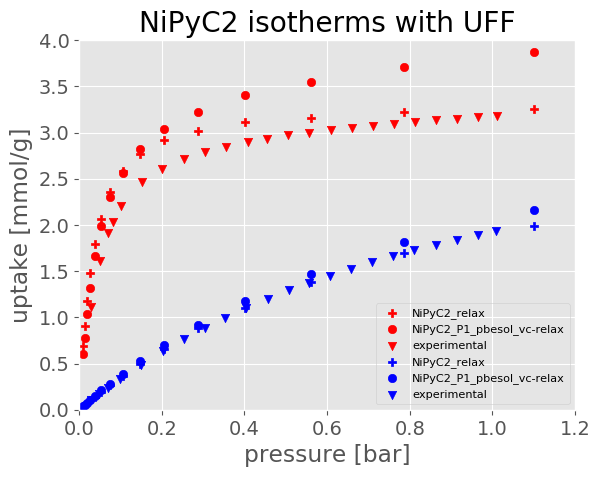

(0, 4.0)

In [10]:
figure()
for gas in adsorbate
    for cof in frameworks
        scatter(cof_to_isotherm[gas][cof][:, Symbol("pressure (bar)")], 
             cof_to_isotherm[gas][cof][:, Symbol("⟨N⟩ (mmol/g)")], 
            label=split(cof,".")[1], marker=cof_to_marker[cof],
            color=adsorbate_to_color[gas])
    end
    scatter(df_exptl_data[gas][1:desorp_onset[gas], Symbol("pressure (bar)")], 
         df_exptl_data[gas][1:desorp_onset[gas], Symbol("⟨N⟩ (mmol/g)")], 
        label="experimental", marker="v",
        color=adsorbate_to_color[gas])
end


legend(loc="best", fontsize="xx-small", 
    facecolor="none") #edgecolor="none"
xlabel("pressure [bar]")
ylabel("uptake [mmol/g]")
title("NiPyC2 isotherms with $ffield")
xlim(xmin=0, xmax=1.2)
ylim(ymin=0, ymax=4.0)
# savefig("NiPyC2_isotherms_with_$ffield.png", format="png")

In [11]:
# figure()
# plot(cof_to_isotherm["NiPyC2_experiment.cif"][:, Symbol("pressure (bar)")], cof_to_isotherm["NiPyC2_experiment.cif"][:, Symbol("fugacity (bar)")], marker="o")
# plot([0, pmax], [0, pmax], color="k", linestyle="--")
# xlabel("pressure (bar)")
# ylabel("fugacity (bar)")
# title("fugacity versus pressure")

In [12]:
# const xe_critical_pressure = 58.420 # bar
# wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

# df_xe_data = CSV.read(wheres_nist_xenon_data)
# p_plot = range(0.0, 350.0, length=100)
# xe_vdw = VdWFluid(:Xe)
# xe_pr = PengRobinsonFluid(:Xe)
# ρ_vdw = [1.0 / calculate_properties(xe_vdw, 298.0, p, verbose=false)["molar volume (L/mol)"] for p in p_plot]
# ρ_pr = [1.0 / calculate_properties(xe_pr, 298.0, p, verbose=false)["molar volume (L/mol)"] for p in p_plot]

# figure()
# plot(p_plot, ρ_vdw, label="vdw EOS")
# plot(p_plot, ρ_pr, label="Peng-Robinson EOS")
# plot(df_xe_data[!, Symbol("Pressure (bar)")], df_xe_data[!, Symbol("Density (mol/l)")], label="NIST")
# axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)
# xlabel("pressure [bar]")
# ylabel("density [mol/L]")
# title("EOS Comparison")
# legend()

# # savefig("xenon_gas_density.png", format="png")